In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

# %cd "/content/drive/My Drive/Colab Notebooks/CS4248/"
# !cd "/content/drive/My Drive/Colab Notebooks/CS4248/"
# !ls

In [2]:
# !pip install wandb
# !pip install datasets
# !pip install transformers==4.6.0
# !pip install evaluate
# !pip install sacrebleu
# !pip install accelerate -U
# !pip install opencc-python-reimplemented
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [3]:
import wandb
import os
import numpy as np
from datasets import load_dataset
from transformers import Seq2SeqTrainingArguments as TrainingArguments
from transformers import Seq2SeqTrainer as Trainer
from transformers import BertTokenizer, EncoderDecoderModel, PreTrainedTokenizerFast
import evaluate
import datetime
#convert to trad
import opencc
import re
#tokenizer stuff
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from collections import defaultdict
import torch
from tqdm import tqdm
from transformers import RobertaTokenizerFast
import spacy
import torchtext

c:\Users\Ishaa\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# INPUT_MAX_LEN = 84
INPUT_MAX_LEN = 58
OUTPUT_MAX_LEN = 32
source_lang = "zh"
target_lang = "en"
# min_freq = 2
# ##TODO: Add spacy, add attention, add logic to end when [SEP]
# #SPACY STILL 35k, wasted

# BOS_TOKEN = "<bos>"
# EOS_TOKEN = "<eos>"
# UNK_TOKEN = "<unk>"
# PAD_TOKEN = "<pad>"
DECODER_EOS = 102
DECODE_PAD_TOKEN = 0

In [5]:
dataset = load_dataset("iwslt2017", "iwslt2017-zh-en", cache_dir="./cache") # optional

In [6]:
# en_tokenizer = spacy.load("en_core_web_sm")
# def tokenize_en(data):
#   data["input"] = [[tok.text.lower() for tok in en_tokenizer(example[target_lang])] for example in data["translation"]]
#   return data

# en_tokenized = dataset.map(tokenize_en, batched=True)

In [7]:
# print(torch.cuda.is_available())

In [8]:
# print(en_tokenized['train'][0])
# special_tokens = [
#   UNK_TOKEN,
#   PAD_TOKEN,
#   BOS_TOKEN,
#   EOS_TOKEN
# ]
# en_vocab = torchtext.vocab.build_vocab_from_iterator(
#     en_tokenized["train"]["input"],
#     min_freq=min_freq,
#     specials=special_tokens,
# )

In [9]:
# print(len(en_vocab))

In [10]:
checkpoint = "google-bert/bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(checkpoint)
tokenizer.bos_token = tokenizer.cls_token
tokenizer.eos_token = tokenizer.sep_token



# Create dict for text into strokes translation and vice versa
with open("zh2letter.txt", 'r', encoding="utf-8") as f:
    conversions = f.read()

conversions = conversions.splitlines()
zh2letter = defaultdict(str)
letter2zh = defaultdict(str)
for line in conversions:
    chinese_char, strokes = line.split()
    zh2letter[chinese_char] = strokes
    letter2zh[strokes] = chinese_char

BPE_file = "BPE_500.json"

# Load the BPE tokenizer from the JSON file
bpe_tokenizer_object = Tokenizer.from_file(BPE_file)
# bpe_tokenizer = RobertaTokenizerFast.from_pretrained("./strokeBERT900", max_len=INPUT_MAX_LEN)
bpe_tokenizer = PreTrainedTokenizerFast(tokenizer_object=bpe_tokenizer_object,return_token_type_ids=True)
# bpe_tokenizer = BertTokenizer.from_pretrained('google-bert/bert-base-chinese')

##DO WE REALLY NEED THIS? But I mean technically it shouldn't matter what we are padding with, eg. if we pad with 3s the model will just learn that 3 is pad
bpe_tokenizer.pad_token = "[PAD]"#tokenizer.pad_token

bpe1000 = Tokenizer.from_file('BPE_1000.json')
bpe5000 = Tokenizer.from_file('BPE_5000.json')
bpe10000 = Tokenizer.from_file('BPE_10000.json')
bpe1000Tokenizer = PreTrainedTokenizerFast(tokenizer_object=bpe1000,return_token_type_ids=True)
bpe5000Tokenizer = PreTrainedTokenizerFast(tokenizer_object=bpe5000,return_token_type_ids=True)
bpe10000Tokenizer = PreTrainedTokenizerFast(tokenizer_object=bpe10000,return_token_type_ids=True)

converter = opencc.OpenCC('s2t')
# text = converter.convert(text)
# strokes = []
# for char in text:
#     if len(zh2letter[char]) > 0:
#         strokes.append(zh2letter[char])




max_len = 0
max_enc = 0
enc_lens = []
enc_lens1000 = []
enc_lens5000 = []
enc_lens10000 = []

com500 = []
com1000 = []
com5000 = []
com10000 = []

# input_lens = []
input_stroke_numbers = []
tot_hasa = 0

ta_freq = 0
gte_freq = 0
ooa_freq = 0
oha_freq = 0
erd_freq = 0
oeeeaiet_freq = 0


def preprocess_function(examples):
    # inputs = [example[source_lang] for example in examples["translation"]]
    inputs = [converter.convert(example[source_lang]) for example in examples["translation"]]
    inputs_stroke = [' '.join([zh2letter[char] for char in text if len(zh2letter[char]) > 0]) for text in inputs]
    for text in inputs:
        has_a = False
        i = 0
        for char in text:            
            if (len(zh2letter[char]) <= 0):
                # print(char, len(char))
                # i += 1
                # if (i > 2):
                #     assert False
                has_a = True
                break
        if has_a:
            global tot_hasa
            tot_hasa += 1

    
    input_lens = []
    complexity = []
    for input in inputs_stroke:
        input_len = 0
        stroke_numbers = []
        input_with_space = str(''.join(input)).split(' ')
        avgt = 0
        for word in input_with_space:
            input_len += 1
            stroke_numbers.append(len(word))
            avgt += len(word)
        input_lens.append(input_len)
        input_stroke_numbers.append(stroke_numbers)
        complexity.append(avgt/input_len)

    # print(inputs[0], inputs_stroke[0], len(inputs[0]), len(inputs_stroke[0]))
    # # print(inputs[0])
    # for i in inputs_stroke:
    #   # print(i)
    #   len_l = len(i)
    #   global max_len
    #   max_len = max(len_l, max_len)
    # #REMOVE
    # print(max_len)
    batch_size = len(inputs_stroke)
    targets = [example[target_lang].lower() for example in examples["translation"]]
    inputs_non_stroke = [example[source_lang] for example in examples["translation"]]

    #84 was calculated to be the upper quartile of the tokenized stroke sentences
    target_tokens = tokenizer(targets, padding='max_length', max_length=OUTPUT_MAX_LEN, truncation=True)
    input_tokens = bpe_tokenizer(inputs_stroke)#,padding='max_length', max_length=INPUT_MAX_LEN, truncation=True)
    # input_tokens = bpe_tokenizer(inputs,padding='max_length', max_length=INPUT_MAX_LEN, truncation=True)

    input_tokens1000 = bpe1000Tokenizer(inputs_stroke)
    input_tokens5000 = bpe5000Tokenizer(inputs_stroke)
    input_tokens10000 = bpe10000Tokenizer(inputs_stroke)

    def get_avg_stroke_nums(tok, tkzr=None):
        # print(tok)
        # actual_tokens = tkzr.convert_ids_to_tokens(tok)
        # print(actual_tokens)
        avgt = 0
        for t in tok:
            global ta_freq, gte_freq, ooa_freq, oha_freq,erd_freq, oeeeaiet_freq
            if t == 'ta':
                ta_freq+= 1
            if t == 'gte':
                gte_freq += 1
            if t == 'ooa':
                ooa_freq += 1
            if t == 'oha':
                oha_freq += 1
            if t == 'erd':
                erd_freq += 1
            if t == 'oeeeaiet':
                oeeeaiet_freq += 1
            avgt += len(t)
        # print(avgt / len(tok))
        if len(tok) is 0:
            return 0
        return avgt / len(tok)

    # get_avg_stroke_nums(input_tokens[0].tokens, bpe_tokenizer)

    for i in range(batch_size):
      # print(input_tokens[0])
      global max_enc, enc_lens
      # print(i)
      len_tok = len(input_tokens[i].tokens)
      len_tok1000 = len(input_tokens1000[i].tokens)
      len_tok5000 = len(input_tokens5000[i].tokens)
      len_tok10000 = len(input_tokens10000[i].tokens)
    #   len_tok = len(input_tokens['input_ids'][i])
      max_enc = max(len_tok, max_enc)
      enc_lens.append(len_tok)
      enc_lens1000.append(len_tok1000)
      enc_lens5000.append(len_tok5000)
      enc_lens10000.append(len_tok10000)
      com500.append(get_avg_stroke_nums(input_tokens[i].tokens))
      com1000.append(get_avg_stroke_nums(input_tokens1000[i].tokens))
      com5000.append(get_avg_stroke_nums(input_tokens5000[i].tokens))
      com10000.append(get_avg_stroke_nums(input_tokens10000[i].tokens))

    # print(input_tokens)
    model_inputs = {
        "input_ids": input_tokens["input_ids"],
        "attention_mask": input_tokens["attention_mask"],
        # "token_type_ids": input_tokens["token_type_ids"],
        "labels": target_tokens["input_ids"],
        "translation": examples["translation"],
        "length": input_lens,
        "complexity": complexity
        }

    #model_inputs = tokenizer(inputs, text_target=targets, padding="max_length", max_length=32, truncation=True)
    # model_inputs["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in model_inputs["labels"]]
    return model_inputs


tokenized_sentences = dataset.map(preprocess_function, batched=True)
print(max_len, max_enc)#, avg_enc/(231266+8594+879))

<>:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Ishaa\AppData\Local\Temp\ipykernel_30520\3736592838.py:150: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if len(tok) is 0:
Map: 100%|██████████| 879/879 [00:00<00:00, 1507.76 examples/s]

0 535


In [11]:
# print(max(enc_lens), sum(enc_lens)/float(len(enc_lens)))
import pandas as pd
# s = pd.Series(enc_lens)
# s.describe()

# print(len(input_lens))
# t = str(''.join(input_stroke_numbers[0])).split(' ')
# print(t)
# print(len(t[0]))
# print(len(t))
# print(input_stroke_numbers[0])
print(tokenized_sentences["test"][2])
print(tot_hasa)
# input_lens_pd = pd.Series(input_lens)
# input_lens_pd.describe()
# input_lens_pd.to_csv('input_lens.csv')
print(ta_freq, gte_freq, ooa_freq, oha_freq, erd_freq, oeeeaiet_freq)

{'translation': {'en': 'The marshmallow has to be on top.', 'zh': '棉花糖必须放在最上面'}, 'input_ids': [274, 123, 80, 48, 473, 169, 85, 38, 140, 55, 23, 29, 107, 207, 198, 308, 49, 163, 41, 404, 279, 269, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'labels': [101, 1996, 9409, 9067, 8261, 2038, 2000, 2022, 2006, 2327, 1012, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'length': 10, 'complexity': 9.0}
6965
16029 6785 2110 613 7939 1611


In [12]:
# input_lens_pd = pd.read_csv('input_lens.csv')
# import matplotlib.pyplot as plt
# from scipy.stats import norm


# mean = input_lens_pd.mean()[1]
# std_dev = input_lens_pd.std()[1]

# lower_bound = mean - 3 * std_dev  # Adjust as needed
# upper_bound = mean + 3 * std_dev  # Adjust as needed

# print(mean,std_dev)


# percentiles = np.percentile(input_lens_pd.iloc[:, 1], [33, 50, 66])
# per = input_lens_pd.iloc[:,1].quantile([0.33, 0.5, 0.66])

In [13]:
# # Step 2: Create Box Plot
# import seaborn as sns
# sns.set_context("poster")

# plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
# percentile_labels = ['33%', '50%', '66%']
# percentiles = per

# # Create the box plot
# plt.boxplot(input_lens_pd.iloc[:, 1], vert=False, showfliers=False)
# for i, percentile in enumerate(percentiles.values.flatten()):
#     plt.scatter(percentile, 1, color='orange', zorder=3)
#     plt.text(percentile, 1, f'{int(percentile)}', fontsize=14, verticalalignment='bottom')
# plt.title('Box Plot of #Words')
# plt.xlabel('Number of Words')
# plt.grid(True)
# plt.show()

In [14]:
# input_stroke_pd = pd.read_csv('input_stroke_numbers.csv', header=None)
# print(input_stroke_pd.shape)

In [15]:
# import math
# data = input_stroke_pd.iloc[1:, 1:]
# print(data.iloc[0,38])
# averages = []
# for index, row in data.iterrows():
#     values = []
#     for col in range(len(row)):
#         num_strokes = data.iloc[index-1,col]
#         if math.isnan(num_strokes):
#             break
#         values.append(num_strokes)
#     values_np = np.asarray(values)
#     averages.append(np.average(values_np))

# # Convert the list of averages to a DataFrame
# averages_df = pd.DataFrame(averages)
# print(averages_df)

In [16]:
# plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
# percentile_labels = ['33%', '50%', '66%']
# percentiles = averages_df.quantile([0.15, 0.5, 0.85])

# # Create the box plot
# plt.boxplot(averages, vert=False, showfliers=False)
# for i, percentile in enumerate(percentiles.values.flatten()):
#     plt.scatter(percentile, 1, color='orange', zorder=3)
#     plt.text(percentile, 1, f'{percentile:.1f}', fontsize=14, verticalalignment='bottom')
# plt.title('Box Plot of Word Complexity')
# plt.xlabel('Average complexity of sentence')
# plt.grid(True)
# plt.show()
# # averages_df.describe()

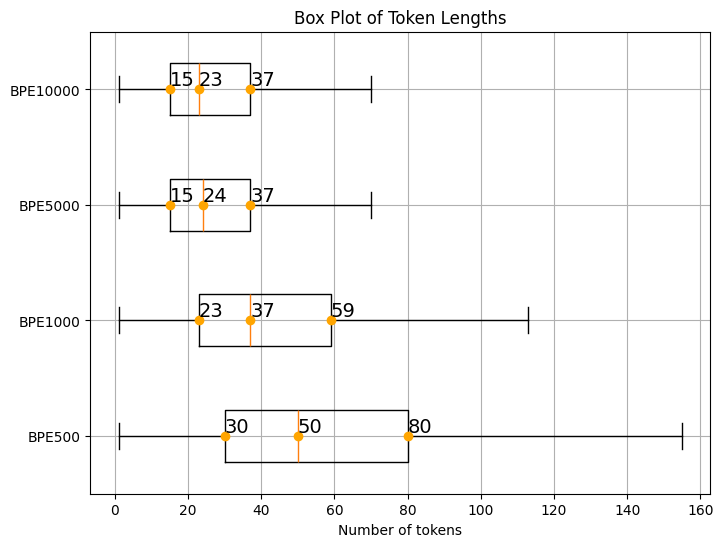

count    9428.000000
mean       61.660161
std        45.619698
min         1.000000
25%        30.000000
50%        50.000000
75%        80.000000
max       535.000000
dtype: float64

In [17]:
s500 = pd.Series(enc_lens)
s1000 = pd.Series(enc_lens1000)
s5000 = pd.Series(enc_lens5000)
s10000 = pd.Series(enc_lens10000)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
percentile_labels = ['25%', '50%', '75%']
percentiles500 = s500.quantile([0.25, 0.5, 0.75])
percentiles1000 = s1000.quantile([0.25, 0.5, 0.75])
percentiles5000 = s5000.quantile([0.25, 0.5, 0.75])
percentiles10000 = s10000.quantile([0.25, 0.5, 0.75])
percentiles = [percentiles500,percentiles1000,percentiles5000,percentiles10000]

boxplotdata = {"BPE500": enc_lens, "BPE1000": enc_lens1000, "BPE5000": enc_lens5000, "BPE10000": enc_lens10000}

# Create the box plot
plt.boxplot(boxplotdata.values(), labels=boxplotdata.keys(), vert=False, showfliers=False)
for j in range(len(percentiles)):
  for i, percentile in enumerate(percentiles[j].values.flatten()):
      plt.scatter(percentile, j+1, color='orange', zorder=3)
      plt.text(percentile, j+1, f'{int(percentile)}', fontsize=14, verticalalignment='bottom')
plt.title('Box Plot of Token Lengths')
plt.xlabel('Number of tokens')
plt.grid(True)
plt.show()

s500.describe()
# s1000.describe()
# s5000.describe()
# s10000.describe()

# s.describe()

In [18]:
# s500 = pd.Series(com500)
# s1000 = pd.Series(com1000)
# s5000 = pd.Series(com5000)
# s10000 = pd.Series(com10000)

# import matplotlib.pyplot as plt

# plt.figure(figsize=(8, 6))  # Adjust the figure size as needed
# percentile_labels = ['25%', '50%', '75%']
# percentiles500 = s500.quantile([0.25, 0.5, 0.75])
# percentiles1000 = s1000.quantile([0.25, 0.5, 0.75])
# percentiles5000 = s5000.quantile([0.25, 0.5, 0.75])
# percentiles10000 = s10000.quantile([0.25, 0.5, 0.75])
# percentiles = [percentiles500,percentiles1000,percentiles5000,percentiles10000]

# boxplotdata = {"BPE500": com500, "BPE1000": com1000, "BPE5000": com5000, "BPE10000": com10000}

# # Create the box plot
# plt.boxplot(boxplotdata.values(), labels=boxplotdata.keys(), vert=False, showfliers=False)
# for j in range(len(percentiles)):
#   for i, percentile in enumerate(percentiles[j].values.flatten()):
#       plt.scatter(percentile, j+1, color='orange', zorder=3)
#       plt.text(percentile, j+1, f'{percentile:.1f}', fontsize=9, verticalalignment='bottom')
# plt.title('Box Plot of Average Number of Strokes')
# plt.xlabel('Average Number of Strokes per word')
# plt.grid(True)
# plt.show()

In [19]:
# input_stroke_numbers_np = pd.DataFrame(input_stroke_numbers)
# input_stroke_numbers_pd = pd.DataFrame(input_stroke_numbers_np)

# input_stroke_numbers_pd.describe()

In [20]:
# input_stroke_numbers_np.to_csv('input_stroke_numbers.csv')

In [21]:
print(tokenized_sentences['train'][0])

{'translation': {'en': "Thank you so much, Chris. And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.", 'zh': '非常谢谢，克里斯。的确非常荣幸 能有第二次站在这个台上的机会，我真是非常感激。'}, 'input_ids': [663, 871, 192, 208, 38, 142, 192, 208, 38, 142, 0, 457, 738, 319, 0, 82, 402, 60, 165, 663, 871, 843, 91, 794, 534, 208, 341, 35, 345, 554, 163, 552, 327, 449, 279, 82, 565, 250, 0, 28, 352, 579, 166, 663, 871, 38, 47, 29, 85, 113, 69, 62, 966, 0, 3, 3, 3, 3], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], 'labels': [101, 4067, 2017, 2061, 2172, 1010, 3782, 1012, 1998, 2009, 1005, 1055, 5621, 1037, 2307, 3932, 2000, 2031, 1996, 4495, 2000, 2272, 2000, 2023, 2754, 3807, 1025, 1045, 1005, 1049, 5186, 102], 'length': 38, 'complexity': 9.131578947368421}


In [22]:
import random
class Encoder(torch.nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, dropout):
    super().__init__()
    self.hidden_size = hidden_size
    self.embedding_size = embedding_size
    self.num_layers = num_layers

    self.embedding = torch.nn.Embedding(input_size, embedding_size)
    self.LSTM = torch.nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, dropout=dropout)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, input_seq):
    word_embeddings = self.embedding(input_seq)
    word_embeddings = self.dropout(word_embeddings)
    outputs, (hidden,cell) = self.LSTM(word_embeddings)
    # print("Encoder", word_embeddings.shape, outputs.shape, hidden.shape, cell.shape)
    return outputs, hidden, cell
  
class DotAttention(torch.nn.Module):
    def __init__(self, hidden_size):
      super(DotAttention, self).__init__()
      # self.hidden_size = hidden_size
      # self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
      # self.v = torch.nn.Linear(hidden_size, 1, bias=False)

    def forward(self, hidden, encoder_outputs):
      seq_len = encoder_outputs.shape[0]
      # print("seq_len", seq_len, encoder_outputs.shape, hidden.shape)
      # hidden = hidden.repeat(seq_len, 1, 1)
      # print(hidden.shape, encoder_outputs.shape)
      enc_out_tr = torch.transpose(encoder_outputs,0,1)
      attention_weights = torch.bmm(enc_out_tr, hidden.unsqueeze(2))
      attention_weights = torch.softmax(attention_weights.squeeze(2), dim=1)
      context = torch.bmm(enc_out_tr.transpose(1,2), attention_weights.unsqueeze(2)).squeeze(2)
      # energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
      # attention = torch.softmax(self.v(energy), dim=0)
      # context = torch.sum(attention * encoder_outputs, dim=0)
      # print("context", context.shape, attention_weights.shape)
      # assert False
      return context
  
# class Attention(torch.nn.Module):
#   def __init__(self, hidden_size):
#       super(Attention, self).__init__()
#       self.hidden_size = hidden_size
#       self.attn = torch.nn.Linear(self.hidden_size * 2, hidden_size)
#       self.v = torch.nn.Linear(hidden_size, 1, bias=False)

#   def forward(self, hidden, encoder_outputs):
#       seq_len = encoder_outputs.shape[0]
#       hidden = hidden.repeat(seq_len, 1, 1)
#       # print(hidden.shape, encoder_outputs.shape)
#       energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2)))
#       attention = torch.softmax(self.v(energy), dim=0)
#       context = torch.sum(attention * encoder_outputs, dim=0)
#       return context

class Decoder(torch.nn.Module):
  def __init__(self, output_size, embedding_size, hidden_size, num_layers, dropout):
    super().__init__()

    self.hidden_size = hidden_size
    self.embedding_size = embedding_size
    self.num_layers = num_layers
    self.output_size = output_size

    self.attention = DotAttention(hidden_size)
    self.embedding = torch.nn.Embedding(output_size, embedding_size)
    #For attention
    self.LSTM = torch.nn.LSTM(embedding_size + hidden_size, hidden_size, num_layers=num_layers, dropout=dropout)
    # self.LSTM = torch.nn.LSTM(embedding_size, hidden_size, num_layers=num_layers, dropout=dropout)
    self.out = torch.nn.Linear(hidden_size, output_size)
    self.dropout = torch.nn.Dropout(dropout)

  def forward(self, input, encoder_outputs, hidden, cell):
    input = input.unsqueeze(0)
    word_embeddings = self.embedding(input)
    word_embeddings = self.dropout(word_embeddings)
    query = hidden[-1]#.permute(1,0,2)
    context = self.attention(query, encoder_outputs)
    context = context.unsqueeze(0)
    word_embeddings = torch.cat((word_embeddings, context), dim=2)
    outputs, (hidden,cell) = self.LSTM(word_embeddings,(hidden, cell))

    outputs = self.out(outputs.squeeze(0))
    return outputs, hidden, cell

class EncoderDecoder(torch.nn.Module):
  def __init__(self,encoder,decoder,device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.device = device
  def forward(self,input,target_output,teacher_forcing_ratio=0.5):
    ##This is why we have to transpose it everytime
    batch_size = target_output.shape[1]
    target_len = target_output.shape[0]
    target_vocab_size = self.decoder.output_size
    
    #This too
    outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(self.device)
    encoder_outputs, hidden, cell = self.encoder(input)

    target_in = target_output[0,:]
    # outputs[0] = target_in

    #Attention mechanism
    #Find a way to cut off after [SEP]
    #Change bert-base-uncased since it has too big of a vocab size

    for t in range(1, target_len):
            #insert input token embedding, previous hidden and previous cell states
            #receive output tensor (predictions) and new hidden and cell states
            output, hidden, cell = self.decoder(target_in, encoder_outputs, hidden, cell)
            #place predictions in a tensor holding predictions for each token
            outputs[t] = output
            #decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            #get the highest predicted token from our predictions
            top1 = output.argmax(1)
            #if teacher forcing, use actual next token as next input
            #if not, use predicted token
            target_in = target_output[t] if teacher_force else top1
    return outputs

In [23]:
print(bpe_tokenizer.vocab_size, tokenizer.vocab_size)

1000 30522


In [24]:
#HYPERPARAMS
BATCH_SIZE = 128 #128
INPUT_DIM = bpe_tokenizer.vocab_size
OUTPUT_DIM = tokenizer.vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.2
DEC_DROPOUT = 0.2
N_EPOCHS = 50
CLIP = 1
EVAL_STEPS = 500
MLM_PROB = 0.15

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
pt_dataset = tokenized_sentences.with_format("torch",columns=["input_ids","labels", "length", "complexity"],device = device)
train_dataloader = torch.utils.data.DataLoader(pt_dataset["train"], batch_size=BATCH_SIZE)
valid_dataloader = torch.utils.data.DataLoader(pt_dataset["validation"], batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(pt_dataset["test"], batch_size=BATCH_SIZE)


cuda


In [26]:
print(pt_dataset['train'][0]['labels'])

tensor([ 101, 4067, 2017, 2061, 2172, 1010, 3782, 1012, 1998, 2009, 1005, 1055,
        5621, 1037, 2307, 3932, 2000, 2031, 1996, 4495, 2000, 2272, 2000, 2023,
        2754, 3807, 1025, 1045, 1005, 1049, 5186,  102], device='cuda:0')


In [27]:
metric = evaluate.load("sacrebleu")
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    # labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
    # print(decoded_preds,decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

In [28]:
import time
import math

def train_fn(model, iterator, optimizer, criterion, clip, device, eval_steps):
    model.train()
    epoch_loss = 0
    eval_it = 0
    with tqdm(total=len(iterator), position=0, leave=True) as pbar:
      for batch in iterator:
          eval_it = (eval_it + 1) % eval_steps
          src = batch["input_ids"].to(device)
          trg = batch["labels"].to(device)
          
          src = torch.transpose(src,0,1)
          trg = torch.transpose(trg,0,1)

          optimizer.zero_grad()
          # try:
          output = model(src, trg)
          if eval_it >= eval_steps - 1:
            org_out = torch.transpose(output,0,1)
            org_trg = torch.transpose(trg,0,1)
            amax = torch.argmax(org_out,dim=-1)
            result = compute_metrics((amax.detach().cpu(),org_trg.detach().cpu()))
            print(result)
          src = src.to(device)
          trg = trg.to(device)
          # except Exception as e:
          #   print(e)
          output_dim = output.shape[-1]

          #removing the [1:]
          output = output[1:].reshape(-1, output_dim)
          trg = trg[1:].reshape(-1)
          loss = criterion(output, trg)

          
          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
          optimizer.step()

          epoch_loss += loss.item()
          pbar.update(1)
    return epoch_loss / len(iterator)

def evaluate_fn(model, iterator, criterion, device, compute_bleu=True):
    model.eval()
    epoch_loss = 0
    bleu = 0
    with torch.no_grad():
        with tqdm(total=len(iterator), position=0, leave=True) as pbar:
          for batch in iterator:
              src = batch["input_ids"].to(device)
              trg = batch["labels"].to(device)
              src = torch.transpose(src,0,1)
              trg = torch.transpose(trg,0,1)

              output = model(src, trg, 0)
              if compute_bleu:
                org_out = torch.transpose(output,0,1)
                org_trg = torch.transpose(trg,0,1)
                amax = torch.argmax(org_out,dim=-1)
                result = compute_metrics((amax.detach().cpu(),org_trg.detach().cpu()))
                bleu += result['bleu']
                # print(result)
              src = src.to(device)
              trg = trg.to(device)

              output_dim = output.shape[-1]

              output = output[1:].reshape(-1, output_dim)
              trg = trg[1:].reshape(-1)

              loss = criterion(output, trg)
              epoch_loss += loss.item()
              pbar.update(1)
              

    return (epoch_loss / len(iterator), bleu / len(iterator))

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def init_weights(m):
    for name, param in m.named_parameters():
        torch.nn.init.uniform_(param.data, -0.08, 0.08)

In [29]:
def train_mlm_fn(model, iterator, optimizer, criterion, clip, device, eval_steps, mlm_prob=0):
    model.train()
    epoch_loss = 0
    eval_it = 0
    with tqdm(total=len(iterator), position=0, leave=True) as pbar:
      for batch in iterator:
          eval_it = (eval_it + 1) % eval_steps
          src = batch["input_ids"].to(device)
          trg = batch["labels"].to(device)
          
          src = torch.transpose(src,0,1)
          trg = torch.transpose(trg,0,1)

          optimizer.zero_grad()

          if mlm_prob > 0:
             mask = torch.rand(src.shape) < mlm_prob
             masked_src = src.clone().to(device)
             #CHANGE TO MASK TOKEN
             masked_src[mask] = 4

          # print(src[:,0], masked_src[:,0])
          # assert False

          # try:
          output = model(masked_src, trg)
          if eval_it >= eval_steps - 1:
            org_out = torch.transpose(output,0,1)
            org_trg = torch.transpose(trg,0,1)
            amax = torch.argmax(org_out,dim=-1)
            result = compute_metrics((amax.detach().cpu(),org_trg.detach().cpu()))
            print(result)
          src = src.to(device)
          trg = trg.to(device)
          # except Exception as e:
          #   print(e)
          output_dim = output.shape[-1]

          #removing the [1:]
          output = output[1:].reshape(-1, output_dim)
          trg = trg[1:].reshape(-1)
          loss = criterion(output, trg)

          
          loss.backward()

          torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
          optimizer.step()

          epoch_loss += loss.item()
          pbar.update(1)
    return epoch_loss / len(iterator)

In [30]:
# t = pt_dataset['train'][0]['labels']
# decoded_preds = tokenizer.batch_decode(t, skip_special_tokens=True)
# labels = np.where(t != -100, t, tokenizer.pad_token_id)
# decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
# print(postprocess_text(decoded_preds,decoded_labels))
# print(compute_metrics((t,t)))

In [31]:
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = EncoderDecoder(enc, dec, device).to(device)
model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters())

#TODO IGNORE INDEX CHANGE TO PAD INDEX
criterion = torch.nn.CrossEntropyLoss(ignore_index = 0)

In [131]:
enc.load_state_dict(torch.load('enc1000mlm.pth'))
dec.load_state_dict(torch.load('dec1000mlm.pth'))
model.load_state_dict(torch.load('encdec1000mlm.pth'))

<All keys matched successfully>

In [33]:
# best_valid_loss = float('inf')
#ADD TQDM
train_losses = []
val_losses = []
val_bleus = []
for epoch in range(N_EPOCHS):

    start_time = time.time()

    # train_loss = train_fn(model, iter(train_dataloader), optimizer, criterion, CLIP,device,EVAL_STEPS)
    train_loss = train_mlm_fn(model, iter(train_dataloader), optimizer, criterion, CLIP,device,EVAL_STEPS, MLM_PROB)
    valid_loss, bleu = evaluate_fn(model, iter(valid_dataloader), criterion,device)

    train_losses.append(train_loss)
    val_losses.append(valid_loss)
    val_bleus.append(bleu)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # if valid_loss < best_valid_loss:
    #     best_valid_loss = valid_loss
    #     torch.save(model.state_dict(), '/content/drive/MyDrive/CS4248 NLP/rnn-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print("bleu", bleu)

 28%|██▊       | 498/1807 [03:02<07:56,  2.75it/s]

{'bleu': 0.2024, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:04<04:55,  2.74it/s]

{'bleu': 0.1941, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:06<01:51,  2.77it/s]

{'bleu': 0.4014, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 01 | Time: 10m 59s
	Train Loss: 5.802 | Train PPL: 330.808
	 Val. Loss: 6.130 |  Val. PPL: 459.297
bleu 0.4701571428571429


 28%|██▊       | 498/1807 [03:00<07:57,  2.74it/s]

{'bleu': 0.7484, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:02<04:57,  2.72it/s]

{'bleu': 1.7276, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:04<01:53,  2.73it/s]

{'bleu': 1.058, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 02 | Time: 10m 58s
	Train Loss: 5.237 | Train PPL: 188.077
	 Val. Loss: 5.991 |  Val. PPL: 399.947
bleu 1.441857142857143


 28%|██▊       | 498/1807 [03:01<07:55,  2.76it/s]

{'bleu': 0.5769, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [05:57<04:46,  2.82it/s]

{'bleu': 2.2624, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [08:52<01:48,  2.85it/s]

{'bleu': 1.1921, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.34it/s]


Epoch: 03 | Time: 10m 44s
	Train Loss: 4.990 | Train PPL: 146.901
	 Val. Loss: 5.862 |  Val. PPL: 351.280
bleu 2.085457142857143


 28%|██▊       | 498/1807 [03:01<07:55,  2.75it/s]

{'bleu': 1.189, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:57,  2.72it/s]

{'bleu': 3.0537, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:52,  2.75it/s]

{'bleu': 2.2848, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch: 04 | Time: 10m 59s
	Train Loss: 4.801 | Train PPL: 121.591
	 Val. Loss: 5.788 |  Val. PPL: 326.503
bleu 2.709857142857143


 28%|██▊       | 498/1807 [03:01<07:59,  2.73it/s]

{'bleu': 1.3158, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:02<04:51,  2.77it/s]

{'bleu': 3.5587, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:02<01:53,  2.73it/s]

{'bleu': 2.9216, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch: 05 | Time: 10m 57s
	Train Loss: 4.660 | Train PPL: 105.617
	 Val. Loss: 5.820 |  Val. PPL: 336.940
bleu 3.215385714285714


 28%|██▊       | 498/1807 [03:01<07:58,  2.73it/s]

{'bleu': 1.0556, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:54,  2.74it/s]

{'bleu': 3.8261, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:53,  2.73it/s]

{'bleu': 3.2662, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 06 | Time: 10m 59s
	Train Loss: 4.526 | Train PPL:  92.408
	 Val. Loss: 5.789 |  Val. PPL: 326.782
bleu 3.3639000000000006


 28%|██▊       | 498/1807 [03:00<07:53,  2.77it/s]

{'bleu': 1.9283, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:00<04:52,  2.77it/s]

{'bleu': 5.1745, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:02<01:52,  2.74it/s]

{'bleu': 3.0023, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch: 07 | Time: 10m 56s
	Train Loss: 4.420 | Train PPL:  83.080
	 Val. Loss: 5.698 |  Val. PPL: 298.238
bleu 3.6918571428571427


 28%|██▊       | 498/1807 [03:01<07:56,  2.75it/s]

{'bleu': 2.9595, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:56,  2.73it/s]

{'bleu': 4.8396, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:53,  2.72it/s]

{'bleu': 3.6001, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch: 08 | Time: 11m 0s
	Train Loss: 4.327 | Train PPL:  75.693
	 Val. Loss: 5.733 |  Val. PPL: 309.023
bleu 4.153314285714285


 28%|██▊       | 498/1807 [02:59<07:57,  2.74it/s]

{'bleu': 3.4714, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:00<04:56,  2.73it/s]

{'bleu': 4.9521, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:02<01:52,  2.74it/s]

{'bleu': 4.1788, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch: 09 | Time: 10m 57s
	Train Loss: 4.250 | Train PPL:  70.097
	 Val. Loss: 5.752 |  Val. PPL: 314.811
bleu 4.205157142857143


 28%|██▊       | 498/1807 [03:01<07:55,  2.75it/s]

{'bleu': 2.3574, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:56,  2.73it/s]

{'bleu': 5.4587, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:53,  2.73it/s]

{'bleu': 3.5697, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch: 10 | Time: 10m 58s
	Train Loss: 4.176 | Train PPL:  65.120
	 Val. Loss: 5.740 |  Val. PPL: 311.163
bleu 4.4111


 28%|██▊       | 498/1807 [02:59<07:58,  2.74it/s]

{'bleu': 3.231, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:02<05:06,  2.64it/s]

{'bleu': 6.0132, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:04<01:53,  2.73it/s]

{'bleu': 4.0997, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch: 11 | Time: 10m 58s
	Train Loss: 4.121 | Train PPL:  61.634
	 Val. Loss: 5.704 |  Val. PPL: 300.001
bleu 4.327042857142857


 28%|██▊       | 498/1807 [03:01<08:00,  2.72it/s]

{'bleu': 2.9974, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:54,  2.74it/s]

{'bleu': 5.5536, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:03<01:51,  2.76it/s]

{'bleu': 4.0419, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.31it/s]


Epoch: 12 | Time: 10m 56s
	Train Loss: 4.057 | Train PPL:  57.786
	 Val. Loss: 5.719 |  Val. PPL: 304.579
bleu 4.5960857142857146


 28%|██▊       | 498/1807 [03:01<07:57,  2.74it/s]

{'bleu': 3.6525, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:55,  2.74it/s]

{'bleu': 6.272, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:53,  2.72it/s]

{'bleu': 4.7153, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch: 13 | Time: 10m 59s
	Train Loss: 4.015 | Train PPL:  55.440
	 Val. Loss: 5.741 |  Val. PPL: 311.467
bleu 5.044785714285714


 28%|██▊       | 498/1807 [03:01<08:00,  2.73it/s]

{'bleu': 3.1224, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:02<04:55,  2.74it/s]

{'bleu': 6.8278, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:02<01:53,  2.73it/s]

{'bleu': 3.881, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 14 | Time: 10m 56s
	Train Loss: 3.960 | Train PPL:  52.480
	 Val. Loss: 5.721 |  Val. PPL: 305.208
bleu 5.028099999999999


 28%|██▊       | 498/1807 [03:01<08:03,  2.71it/s]

{'bleu': 2.9933, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:53,  2.76it/s]

{'bleu': 6.1698, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:52,  2.74it/s]

{'bleu': 4.927, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch: 15 | Time: 11m 0s
	Train Loss: 3.916 | Train PPL:  50.209
	 Val. Loss: 5.726 |  Val. PPL: 306.638
bleu 5.149571428571429


 28%|██▊       | 498/1807 [03:01<07:54,  2.76it/s]

{'bleu': 4.3566, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:00<04:50,  2.78it/s]

{'bleu': 6.1134, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:02<01:52,  2.75it/s]

{'bleu': 4.8098, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 16 | Time: 10m 57s
	Train Loss: 3.877 | Train PPL:  48.267
	 Val. Loss: 5.791 |  Val. PPL: 327.484
bleu 5.336114285714286


 28%|██▊       | 498/1807 [03:01<08:02,  2.71it/s]

{'bleu': 2.96, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:55,  2.74it/s]

{'bleu': 5.6129, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:52,  2.74it/s]

{'bleu': 5.7593, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch: 17 | Time: 11m 0s
	Train Loss: 3.834 | Train PPL:  46.268
	 Val. Loss: 5.803 |  Val. PPL: 331.292
bleu 5.5184428571428565


 28%|██▊       | 498/1807 [02:59<07:51,  2.78it/s]

{'bleu': 3.9959, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [05:59<04:54,  2.75it/s]

{'bleu': 6.9587, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:01<01:53,  2.73it/s]

{'bleu': 5.4816, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 18 | Time: 10m 56s
	Train Loss: 3.810 | Train PPL:  45.147
	 Val. Loss: 5.734 |  Val. PPL: 309.062
bleu 5.276714285714285


 28%|██▊       | 498/1807 [03:01<07:58,  2.73it/s]

{'bleu': 4.2454, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:02<04:57,  2.72it/s]

{'bleu': 7.076, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:04<01:52,  2.75it/s]

{'bleu': 6.2821, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch: 19 | Time: 10m 59s
	Train Loss: 3.769 | Train PPL:  43.337
	 Val. Loss: 5.733 |  Val. PPL: 308.823
bleu 5.581985714285714


 28%|██▊       | 498/1807 [02:58<07:50,  2.78it/s]

{'bleu': 4.7181, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:00<04:55,  2.74it/s]

{'bleu': 6.5804, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:02<01:53,  2.73it/s]

{'bleu': 6.2289, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch: 20 | Time: 10m 57s
	Train Loss: 3.746 | Train PPL:  42.346
	 Val. Loss: 5.731 |  Val. PPL: 308.375
bleu 5.281071428571429


 28%|██▊       | 498/1807 [03:01<07:56,  2.75it/s]

{'bleu': 4.5384, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:55,  2.73it/s]

{'bleu': 7.2407, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:04<01:50,  2.79it/s]

{'bleu': 6.3885, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch: 21 | Time: 10m 57s
	Train Loss: 3.706 | Train PPL:  40.696
	 Val. Loss: 5.825 |  Val. PPL: 338.530
bleu 5.732085714285715


 28%|██▊       | 498/1807 [02:59<07:59,  2.73it/s]

{'bleu': 4.1733, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:01<04:55,  2.74it/s]

{'bleu': 6.6715, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:04<01:53,  2.73it/s]

{'bleu': 7.2913, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 22 | Time: 10m 58s
	Train Loss: 3.684 | Train PPL:  39.802
	 Val. Loss: 5.846 |  Val. PPL: 345.953
bleu 5.798157142857143


 28%|██▊       | 498/1807 [03:01<07:57,  2.74it/s]

{'bleu': 3.315, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:55,  2.73it/s]

{'bleu': 9.097, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:03<01:51,  2.77it/s]

{'bleu': 6.559, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch: 23 | Time: 10m 57s
	Train Loss: 3.662 | Train PPL:  38.954
	 Val. Loss: 5.885 |  Val. PPL: 359.681
bleu 6.0558


 28%|██▊       | 498/1807 [03:01<08:00,  2.72it/s]

{'bleu': 4.1729, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:55,  2.73it/s]

{'bleu': 7.509, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:52,  2.75it/s]

{'bleu': 6.8335, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch: 24 | Time: 11m 0s
	Train Loss: 3.630 | Train PPL:  37.715
	 Val. Loss: 5.791 |  Val. PPL: 327.295
bleu 5.7966


 28%|██▊       | 498/1807 [03:01<08:00,  2.72it/s]

{'bleu': 4.371, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:02<04:53,  2.76it/s]

{'bleu': 6.9844, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:02<01:54,  2.71it/s]

{'bleu': 5.9455, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  2.96it/s]


Epoch: 25 | Time: 10m 57s
	Train Loss: 3.608 | Train PPL:  36.897
	 Val. Loss: 5.829 |  Val. PPL: 339.965
bleu 5.554257142857144


 28%|██▊       | 498/1807 [03:01<07:57,  2.74it/s]

{'bleu': 5.4234, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:52,  2.76it/s]

{'bleu': 8.433, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:52,  2.74it/s]

{'bleu': 6.2165, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch: 26 | Time: 10m 59s
	Train Loss: 3.589 | Train PPL:  36.202
	 Val. Loss: 5.865 |  Val. PPL: 352.599
bleu 5.9227


 28%|██▊       | 498/1807 [03:00<07:51,  2.78it/s]

{'bleu': 5.0929, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:00<04:52,  2.77it/s]

{'bleu': 8.2962, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:02<01:53,  2.73it/s]

{'bleu': 8.0965, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch: 27 | Time: 10m 57s
	Train Loss: 3.573 | Train PPL:  35.636
	 Val. Loss: 5.774 |  Val. PPL: 321.780
bleu 5.372142857142856


 28%|██▊       | 498/1807 [03:01<07:57,  2.74it/s]

{'bleu': 3.9357, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:54,  2.75it/s]

{'bleu': 7.9995, 'gen_len': 31.0}


 83%|████████▎ | 1499/1807 [09:05<02:05,  2.46it/s]

{'bleu': 9.1883, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch: 28 | Time: 11m 0s
	Train Loss: 3.548 | Train PPL:  34.732
	 Val. Loss: 5.861 |  Val. PPL: 350.978
bleu 5.802300000000001


 28%|██▊       | 498/1807 [02:59<07:52,  2.77it/s]

{'bleu': 4.9236, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [05:59<04:57,  2.72it/s]

{'bleu': 7.2191, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:02<01:52,  2.74it/s]

{'bleu': 9.6467, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch: 29 | Time: 10m 56s
	Train Loss: 3.532 | Train PPL:  34.189
	 Val. Loss: 5.892 |  Val. PPL: 361.949
bleu 6.036842857142858


 28%|██▊       | 498/1807 [03:01<07:58,  2.74it/s]

{'bleu': 5.1517, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:58,  2.71it/s]

{'bleu': 7.97, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:52,  2.74it/s]

{'bleu': 7.9261, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch: 30 | Time: 10m 58s
	Train Loss: 3.510 | Train PPL:  33.450
	 Val. Loss: 5.926 |  Val. PPL: 374.489
bleu 6.246071428571428


 28%|██▊       | 498/1807 [02:59<07:57,  2.74it/s]

{'bleu': 4.767, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:01<04:59,  2.70it/s]

{'bleu': 8.4777, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:03<01:53,  2.73it/s]

{'bleu': 10.29, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.22it/s]


Epoch: 31 | Time: 10m 58s
	Train Loss: 3.500 | Train PPL:  33.114
	 Val. Loss: 5.838 |  Val. PPL: 343.205
bleu 5.698628571428571


 28%|██▊       | 498/1807 [03:01<08:01,  2.72it/s]

{'bleu': 5.3478, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:56,  2.73it/s]

{'bleu': 7.8337, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:04<01:51,  2.77it/s]

{'bleu': 8.7673, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 32 | Time: 10m 57s
	Train Loss: 3.478 | Train PPL:  32.401
	 Val. Loss: 5.892 |  Val. PPL: 362.133
bleu 5.864185714285715


 28%|██▊       | 498/1807 [03:00<08:00,  2.73it/s]

{'bleu': 5.9079, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:55,  2.74it/s]

{'bleu': 8.2706, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:53,  2.73it/s]

{'bleu': 8.469, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch: 33 | Time: 10m 59s
	Train Loss: 3.462 | Train PPL:  31.877
	 Val. Loss: 5.922 |  Val. PPL: 373.077
bleu 5.823485714285714


 28%|██▊       | 498/1807 [03:01<07:57,  2.74it/s]

{'bleu': 5.7738, 'gen_len': 31.0}


 55%|█████▌    | 999/1807 [06:03<05:24,  2.49it/s]

{'bleu': 8.3081, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:03<01:51,  2.76it/s]

{'bleu': 7.9781, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch: 34 | Time: 10m 57s
	Train Loss: 3.450 | Train PPL:  31.508
	 Val. Loss: 5.929 |  Val. PPL: 375.891
bleu 6.037871428571428


 28%|██▊       | 498/1807 [03:01<07:58,  2.74it/s]

{'bleu': 6.263, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:55,  2.74it/s]

{'bleu': 9.7887, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:53,  2.73it/s]

{'bleu': 10.0261, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch: 35 | Time: 11m 0s
	Train Loss: 3.438 | Train PPL:  31.122
	 Val. Loss: 5.969 |  Val. PPL: 391.036
bleu 6.0065285714285706


 28%|██▊       | 498/1807 [03:01<07:57,  2.74it/s]

{'bleu': 6.3093, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:01<04:51,  2.78it/s]

{'bleu': 8.9036, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:02<01:53,  2.73it/s]

{'bleu': 8.8831, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch: 36 | Time: 10m 57s
	Train Loss: 3.422 | Train PPL:  30.618
	 Val. Loss: 5.954 |  Val. PPL: 385.163
bleu 5.920757142857142


 28%|██▊       | 498/1807 [03:01<07:58,  2.74it/s]

{'bleu': 6.0857, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:56,  2.73it/s]

{'bleu': 9.4321, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:05<01:52,  2.74it/s]

{'bleu': 9.0531, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.24it/s]


Epoch: 37 | Time: 11m 0s
	Train Loss: 3.410 | Train PPL:  30.278
	 Val. Loss: 5.964 |  Val. PPL: 389.292
bleu 5.992642857142857


 28%|██▊       | 498/1807 [02:59<07:53,  2.76it/s]

{'bleu': 5.9638, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:00<04:55,  2.74it/s]

{'bleu': 9.0632, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:02<01:52,  2.74it/s]

{'bleu': 8.8486, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch: 38 | Time: 10m 56s
	Train Loss: 3.392 | Train PPL:  29.712
	 Val. Loss: 6.021 |  Val. PPL: 412.032
bleu 5.936014285714286


 28%|██▊       | 498/1807 [03:01<07:57,  2.74it/s]

{'bleu': 5.8256, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:03<04:57,  2.72it/s]

{'bleu': 8.9442, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:03<01:51,  2.78it/s]

{'bleu': 10.6942, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.28it/s]


Epoch: 39 | Time: 10m 56s
	Train Loss: 3.383 | Train PPL:  29.450
	 Val. Loss: 5.958 |  Val. PPL: 386.658
bleu 5.830114285714286


 28%|██▊       | 498/1807 [02:59<07:50,  2.78it/s]

{'bleu': 7.1204, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:00<04:58,  2.71it/s]

{'bleu': 7.6829, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:01<01:51,  2.76it/s]

{'bleu': 8.6624, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 40 | Time: 10m 54s
	Train Loss: 3.360 | Train PPL:  28.787
	 Val. Loss: 6.004 |  Val. PPL: 405.212
bleu 6.314814285714286


 28%|██▊       | 498/1807 [03:01<08:00,  2.72it/s]

{'bleu': 7.3964, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:01<04:52,  2.76it/s]

{'bleu': 7.0961, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:01<01:50,  2.79it/s]

{'bleu': 9.2543, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


Epoch: 41 | Time: 10m 54s
	Train Loss: 3.355 | Train PPL:  28.652
	 Val. Loss: 6.008 |  Val. PPL: 406.695
bleu 6.307671428571429


 28%|██▊       | 498/1807 [02:59<07:59,  2.73it/s]

{'bleu': 7.5494, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:01<04:52,  2.77it/s]

{'bleu': 8.1548, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:01<01:51,  2.78it/s]

{'bleu': 8.9684, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch: 42 | Time: 10m 55s
	Train Loss: 3.348 | Train PPL:  28.438
	 Val. Loss: 6.036 |  Val. PPL: 418.340
bleu 6.182585714285714


 28%|██▊       | 498/1807 [03:00<07:49,  2.79it/s]

{'bleu': 6.5973, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:00<04:51,  2.77it/s]

{'bleu': 8.4166, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:00<01:51,  2.78it/s]

{'bleu': 11.3261, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 43 | Time: 10m 53s
	Train Loss: 3.337 | Train PPL:  28.127
	 Val. Loss: 6.035 |  Val. PPL: 417.630
bleu 6.081928571428572


 28%|██▊       | 498/1807 [03:01<07:57,  2.74it/s]

{'bleu': 6.6323, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:01<04:51,  2.78it/s]

{'bleu': 9.5125, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:01<01:53,  2.73it/s]

{'bleu': 9.0314, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.27it/s]


Epoch: 44 | Time: 10m 56s
	Train Loss: 3.327 | Train PPL:  27.855
	 Val. Loss: 6.017 |  Val. PPL: 410.466
bleu 6.181171428571429


 28%|██▊       | 498/1807 [02:59<07:50,  2.78it/s]

{'bleu': 5.8935, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [05:58<04:50,  2.78it/s]

{'bleu': 9.5794, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [08:59<01:53,  2.72it/s]

{'bleu': 9.9662, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.23it/s]


Epoch: 45 | Time: 10m 53s
	Train Loss: 3.310 | Train PPL:  27.385
	 Val. Loss: 6.038 |  Val. PPL: 418.888
bleu 6.2757571428571435


 28%|██▊       | 498/1807 [02:59<07:52,  2.77it/s]

{'bleu': 5.9607, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:00<04:53,  2.75it/s]

{'bleu': 9.9546, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:02<01:52,  2.74it/s]

{'bleu': 9.4668, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 46 | Time: 10m 55s
	Train Loss: 3.295 | Train PPL:  26.965
	 Val. Loss: 6.039 |  Val. PPL: 419.292
bleu 6.099385714285715


 28%|██▊       | 498/1807 [02:58<07:51,  2.78it/s]

{'bleu': 7.4832, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [05:58<04:50,  2.78it/s]

{'bleu': 9.2149, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:00<01:52,  2.74it/s]

{'bleu': 10.3219, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.25it/s]


Epoch: 47 | Time: 10m 54s
	Train Loss: 3.289 | Train PPL:  26.816
	 Val. Loss: 6.035 |  Val. PPL: 417.631
bleu 6.184971428571428


 28%|██▊       | 498/1807 [02:59<07:50,  2.79it/s]

{'bleu': 8.1699, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:00<04:56,  2.73it/s]

{'bleu': 9.672, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:01<01:51,  2.76it/s]

{'bleu': 8.9198, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.26it/s]


Epoch: 48 | Time: 10m 54s
	Train Loss: 3.272 | Train PPL:  26.365
	 Val. Loss: 6.117 |  Val. PPL: 453.459
bleu 6.126414285714286


 28%|██▊       | 498/1807 [02:59<07:50,  2.78it/s]

{'bleu': 7.6418, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [05:59<04:54,  2.75it/s]

{'bleu': 10.1301, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:01<01:51,  2.78it/s]

{'bleu': 9.5298, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.29it/s]


Epoch: 49 | Time: 10m 54s
	Train Loss: 3.269 | Train PPL:  26.298
	 Val. Loss: 6.076 |  Val. PPL: 435.313
bleu 5.933199999999999


 28%|██▊       | 498/1807 [02:59<07:56,  2.74it/s]

{'bleu': 8.5536, 'gen_len': 31.0}


 55%|█████▌    | 998/1807 [06:01<04:51,  2.78it/s]

{'bleu': 9.9637, 'gen_len': 31.0}


 83%|████████▎ | 1498/1807 [09:01<01:51,  2.78it/s]

{'bleu': 9.9147, 'gen_len': 31.0}


100%|██████████| 7/7 [00:02<00:00,  3.30it/s]

Epoch: 50 | Time: 10m 54s
	Train Loss: 3.268 | Train PPL:  26.246
	 Val. Loss: 6.101 |  Val. PPL: 446.176
bleu 6.312757142857143


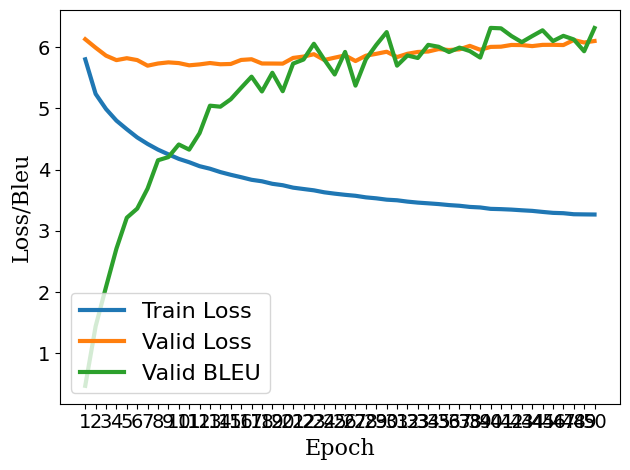

In [34]:
# train_losses = []
# val_losses = []
# val_bleus = []
from matplotlib import pyplot as plt
x = list(range(1, len(train_losses) + 1))
plt.figure()

plt.plot(x,train_losses, lw=3)
plt.plot(x,val_losses,lw=3)
plt.plot(x,val_bleus,lw=3)

font_axes = {'family':'serif','color':'black','size':16}

plt.gca().set_xticks(x)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Epoch", fontdict=font_axes)
plt.ylabel("Loss/Bleu", fontdict=font_axes)
plt.legend(['Train Loss', 'Valid Loss', 'Valid BLEU'], loc='lower left', fontsize=16)
plt.tight_layout()
plt.show()

In [35]:
print(train_losses)
print(val_losses)
print(val_bleus)

[5.80153733561167, 5.236849253390069, 4.989759910944488, 4.8006601312507495, 4.659820189446986, 4.5262183544051275, 4.4198054289646285, 4.32669158923936, 4.2498828648333395, 4.176232959792703, 4.121214342302028, 4.056750690336708, 4.015308961725789, 3.9604373112790943, 3.916204035842887, 3.876753839789403, 3.834451650741949, 3.8099341608901414, 3.7690156730552635, 3.7458713557354706, 3.706139663338463, 3.6839250588060812, 3.6623731279610663, 3.630053156307539, 3.6081329417215504, 3.589103131777157, 3.573351732722685, 3.5476575920313977, 3.5318928984033513, 3.5100377402915175, 3.4999552438057253, 3.478189977942479, 3.461875557437679, 3.450244014937375, 3.4379181665284366, 3.421593295848363, 3.4104076426663843, 3.391555803021345, 3.382706762217789, 3.3599401455791074, 3.3552248434395042, 3.347743156804653, 3.3367465675767773, 3.3269983285292777, 3.3100019864239085, 3.2945371675570496, 3.2889943976526306, 3.272050185828956, 3.2694787890725063, 3.267526874373351]
[6.129696028573172, 5.9913

In [50]:
input_aw = pt_dataset['test'][0:128]['input_ids']
trg_aw = pt_dataset['test'][0:128]['labels']
input_aw = torch.transpose(input_aw,0,1)
trg_aw = torch.transpose(trg_aw,0,1)


In [51]:
output = model(input_aw, trg_aw, 0)
# output_dim = output.shape[-1]
#TODO MAKE SURE EVERYTHING LOOKS FINE, PRINT STUFF OUT AND ALL
# output = output[1:].reshape(-1, output_dim)
# decoded_preds = tokenizer.batch_decode(output, skip_special_tokens=True)
trg_aw = torch.transpose(trg_aw,0,1)
output = torch.transpose(output,0,1)
decoded_labels = tokenizer.batch_decode(trg_aw, skip_special_tokens=True)
# print(compute_metrics((output,trg_aw)))
print(output.shape)

torch.Size([128, 32, 30522])


In [52]:
output_dim = output.shape[-1]
test_o = output[1:].reshape(-1, output_dim)
test_t = trg_aw.reshape(-1)
# amax = np.argmax(output,axis=-1)
amax = torch.argmax(output,dim=-1)
print(trg_aw.shape, output.shape, amax.shape)

torch.Size([128, 32]) torch.Size([128, 32, 30522]) torch.Size([128, 32])


In [53]:
print(trg_aw[7])
print(amax[7])

tensor([  101,  2061,  1010,  5373,  1010,  2087,  2111,  4088,  2011, 16865,
         2075,  3209,  2000,  1996,  4708,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0], device='cuda:0')
tensor([   0, 1998, 1010, 2111, 5373, 2411, 1996, 2111, 2000, 2000, 2079, 2009,
        1012,  102, 1012,  102,  102,  102,  102,  102,  102,  102,  102,  102,
         102,  102,  102,  102,  102,  102,  102,  102], device='cuda:0')


In [54]:
decoded_preds = tokenizer.batch_decode(amax, skip_special_tokens=True)

In [60]:
print(decoded_preds[9])
print(decoded_labels[9])

and then time time,,,, they scan them and they read it and and then it spaghetti spaghetti.
then they spend some time planning, organizing, they sketch and they lay out spaghetti.


In [61]:
print(compute_metrics((amax[9:10].detach().cpu(),trg_aw[9:10].detach().cpu())))

{'bleu': 6.6216, 'gen_len': 31.0}


In [33]:
# # test_dataloader2 = torch.utils.data.DataLoader(pt_dataset["test"], batch_size=128)

# _, bleu = evaluate_fn(model, iter(test_dataloader), criterion,device)
# print("Test BLEU:", bleu)

100%|██████████| 67/67 [00:21<00:00,  3.10it/s]

Test BLEU: 9.006747761194033


In [82]:
# def compute_metrics(eval_preds):
#     preds, labels = eval_preds
#     if isinstance(preds, tuple):
#         preds = preds[0]
#     decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

#     # labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
#     decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

#     decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
#     # print(decoded_preds,decoded_labels)

#     result = metric.compute(predictions=decoded_preds, references=decoded_labels)
#     result = {"bleu": result["score"]}

#     prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
#     result["gen_len"] = np.mean(prediction_lens)
#     result = {k: round(v, 4) for k, v in result.items()}
#     return result
all_preds = []
all_labels = []
def evaluate_bleu(model, iterator, criterion, device, compute_bleu=True):
    model.eval()
    epoch_loss = 0
    bleu = 0
    with torch.no_grad():
        with tqdm(total=len(iterator), position=0, leave=True) as pbar:
          for batch in iterator:
              src = batch["input_ids"].to(device)
              trg = batch["labels"].to(device)
              lengths = batch["length"]
              complexity = batch["complexity"]
              # print(batch["complexity"])
              # assert False


              mask = torch.logical_and(complexity >= 7.5, complexity < 9.6)

              # filter_indices = complexity > 9.6#torch.nonzero(mask).squeeze()
              # src = src[filter_indices]
              # trg = trg[filter_indices]


              # print(batch["length"][filter_indices])
              # assert False

              src = torch.transpose(src,0,1)
              trg = torch.transpose(trg,0,1)

              output = model(src, trg, 0)
              if compute_bleu:
                org_out = torch.transpose(output,0,1)
                org_trg = torch.transpose(trg,0,1)
                amax = torch.argmax(org_out,dim=-1)
                preds = amax.detach().cpu()
                labels = org_trg.detach().cpu()
                if isinstance(preds, tuple):
                   preds = preds[0]
                decoded_preds = tokenizer.batch_decode(preds,skip_special_tokens=True)
                decoded_labels = tokenizer.batch_decode(labels,skip_special_tokens=True)
                decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)
                all_labels.extend(decoded_labels)
                all_preds.extend(decoded_preds)
                # result = compute_metrics((amax.detach().cpu(),org_trg.detach().cpu()))
                # bleu += result['bleu']
                # print(result)
              src = src.to(device)
              trg = trg.to(device)

              output_dim = output.shape[-1]

              output = output[1:].reshape(-1, output_dim)
              trg = trg[1:].reshape(-1)

              loss = criterion(output, trg)
              epoch_loss += loss.item()
              pbar.update(1)
              

    return (epoch_loss / len(iterator), bleu / len(iterator))
# test_dataloader2 = torch.utils.data.DataLoader(pt_dataset["test"], batch_size=64)
_, bleu = evaluate_bleu(model, iter(test_dataloader), criterion,device)

100%|██████████| 67/67 [00:19<00:00,  3.52it/s]


In [83]:
print(all_labels[0], all_preds[0], len(all_labels), len(all_preds))
result = metric.compute(predictions=all_preds, references=all_labels)
print(result)

['several years ago here at ted, peter skillman introduced a design challenge called the marshmallow challenge.'] a few years ago, in the,, a design a challenge called " " " " " ". " " " " " 8549 8549
{'score': 9.341681541095966, 'counts': [57420, 18546, 7203, 3005], 'totals': [141939, 133390, 124841, 116297], 'precisions': [40.45399784414432, 13.90359097383612, 5.769739108145561, 2.583901562379081], 'bp': 0.9762137388611822, 'sys_len': 141939, 'ref_len': 145356}


In [129]:
# valid_dataloader2 = torch.utils.data.DataLoader(pt_dataset["validation"], batch_size=128)
# _, bleu = evaluate_fn(model, iter(valid_dataloader2), criterion,device)
# print("Valid BLEU:", bleu)

100%|██████████| 7/7 [00:02<00:00,  2.91it/s]

Valid BLEU: 3.5523


In [134]:
def translate_sentence(
    sentence,
    model,
    device,
    max_output_length=25,
    inda=0,
    rad=False,
):
    model.eval()
    with torch.no_grad():
        trad = converter.convert(sentence)
        print(trad)
        stroke = ' '.join([zh2letter[char] for char in trad if (len(zh2letter[char]) > 0)])
        if rad:
            stroke = sentence
        print(stroke)
        # stroke = trad

        ids = bpe_tokenizer(stroke,padding='max_length', max_length=INPUT_MAX_LEN, truncation=True)
        print(ids)
        src = torch.LongTensor(ids["input_ids"]).unsqueeze(-1).to(device)


        src = torch.where(src==0, torch.tensor(4), src)


        print(src.shape)
        # src = torch.transpose(src,0,1)
        trg = torch.zeros_like(src).to(device)
        print(src.shape, trg.shape)
        output = model(src, trg, 0)
        # enc_out = model.encoder.embedding(src)#, _, _ = model.encoder(src)
        enc_out, hidden, cell = model.encoder(src)
        print(output.shape)
        # encoded_hidden, cell = model.encoder(src)
        # for i in range(max_output_length):
        org_out = torch.transpose(output,0,1)
        amax = torch.argmax(org_out,dim=-1)
        preds = amax.detach().cpu()
        print(preds.shape)
        decoded_preds = tokenizer.batch_decode(preds,skip_special_tokens=True)
        print(decoded_preds)
        word1 = enc_out[inda].flatten()
        # word2 = enc_out[1].flatten()
        # cos_sim = torch.nn.functional.cosine_similarity(word1,word2,dim=0)
        # print("Similarity",cos_sim,word2.shape,word1.shape)
    return word1, enc_out, hidden, cell

sentence = "ta..."
# tok = bpe_tokenizer(sentence)
# print(tok['in'])
a,aa,aahid, aacell = translate_sentence(sentence, model=model, device=device, inda=0, rad=True)

ta...
ta...
{'input_ids': [45, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
torch.Size([58, 1])
torch.Size([58, 1]) torch.Size([58, 1])
torch.Size([58, 1, 30522])
torch.Size([1, 58])
['you.']


In [125]:
sentence = "言"
b, bb, bbhid, bbcell = translate_sentence(sentence, model=model, device=device,inda=0)
cos_sim = torch.nn.functional.cosine_similarity(a,b,dim=0)
print(cos_sim)

言
oeeeaie0
{'input_ids': [121, 5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
torch.Size([58, 1])
torch.Size([58, 1]) torch.Size([58, 1])
torch.Size([58, 1, 30522])
torch.Size([1, 58])
['talk..']
tensor(1., device='cuda:0')


In [230]:
sentence = "ta"
c, cc, cchid, cccell = translate_sentence(sentence, model=model, device=device,inda=0, rad=True)

ta
ta
{'input_ids': [45, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
torch.Size([84, 1])
torch.Size([84, 1]) torch.Size([84, 1])
torch.Size([84, 1, 30522])
torch.Size([1, 84])
['js : yeah..egans.eganegansegan d']


In [231]:
sentence = "gte"
d, dd, ddhid, ddcell = translate_sentence(sentence, model=model, device=device,inda=0, rad=True)

gte
gte
{'input_ids': [128, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}
torch.Size([84, 1])
torch.Size([84, 1]) torch.Size([84, 1])
torch.Size([84, 1, 30522])
torch.Size([1, 84])
['ok.....']


In [236]:
e = a - c + d
ee = aa - cc + dd
eehid = aahid - cchid + ddhid
eecell = aacell - cccell + ddcell
cos_sim = torch.nn.functional.cosine_similarity(e,b,dim=0)
print(cos_sim)

tensor(0.4484, device='cuda:0')


In [157]:
# import torch
# import torch.nn.functional as F

# tensor1 = torch.randn(1, 512) 
# tensor2 = -torch.randn(1, 512) 
# similarity_score = F.cosine_similarity(tensor1.flatten(), tensor2.flatten(), dim=0)
# print("Cosine Similarity:", similarity_score.item())

Cosine Similarity: -0.1402246206998825


In [237]:
print(model)

EncoderDecoder(
  (encoder): Encoder(
    (embedding): Embedding(500, 256)
    (LSTM): LSTM(256, 512, num_layers=2, dropout=0.2)
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (decoder): Decoder(
    (attention): DotAttention()
    (embedding): Embedding(30522, 256)
    (LSTM): LSTM(768, 512, num_layers=2, dropout=0.2)
    (out): Linear(in_features=512, out_features=30522, bias=True)
    (dropout): Dropout(p=0.2, inplace=False)
  )
)


In [88]:
# torch.save(model.state_dict(), 'encdec1000mlm.pth')
# torch.save(enc.state_dict(),'enc1000mlm.pth')
# torch.save(dec.state_dict(), 'dec1000mlm.pth')

In [ ]:
import time
import math

def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        src = batch["input"]
        trg = batch["target"]
        src = torch.transpose(src,0,1)
        trg = torch.transpose(trg,0,1)

        optimizer.zero_grad()
        output = model(src, trg)
        output_dim = output.shape[-1]

        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)
        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def train_mlm(model, iterator, optimizer, criterion, clip, mlm_prob):
    model.train()
    epoch_loss = 0
    for batch in iterator:
        src = batch["input"]
        trg = batch["target"]
        src = torch.transpose(src,0,1)
        trg = torch.transpose(trg,0,1)

        optimizer.zero_grad()
        

        output = model(src, trg)
        output_dim = output.shape[-1]

        output = output[1:].reshape(-1, output_dim)
        trg = trg[1:].reshape(-1)
        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()

        epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in iterator:
            src = batch["input"]
            trg = batch["target"]
            src = torch.transpose(src,0,1)
            trg = torch.transpose(trg,0,1)

            output = model(src, trg, 0)
            output_dim = output.shape[-1]

            output = output[1:].reshape(-1, output_dim)
            trg = trg[1:].reshape(-1)

            loss = criterion(output, trg)
            epoch_loss += loss.item()

    return epoch_loss / len(iterator)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def init_weights(m):
    for name, param in m.named_parameters():
        torch.nn.init.uniform_(param.data, -0.08, 0.08)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pt_dataset = tokenized_sentences.with_format("torch",columns=["input","target"],device = device)
pt_dataset = pt_dataset.train_test_split(test_size=0.2)
train_dataloader = torch.utils.data.DataLoader(pt_dataset["train"], batch_size=10)
valid_dataloader = torch.utils.data.DataLoader(pt_dataset["test"], batch_size=10)

#parameters

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)
model = EncoderDecoder(enc, dec, device).to(device)
model.apply(init_weights)
optimizer = torch.optim.Adam(model.parameters())
criterion = torch.nn.CrossEntropyLoss(ignore_index = 2)

best_valid_loss = float('inf')
N_EPOCHS = 10
CLIP = 1
for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, iter(train_dataloader), optimizer, criterion, CLIP)
    valid_loss = evaluate(model, iter(valid_dataloader), criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/CS4248 NLP/rnn-model.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

In [ ]:
# source_lang = "en"
# target_lang = "zh"

# def preprocess_function(examples):
#     inputs = [example[source_lang] for example in examples["translation"]]
#     targets = [example[target_lang] for example in examples["translation"]]
#     model_inputs = tokenizer(inputs, text_target=targets, padding="max_length", max_length=32, truncation=True)
#     model_inputs["labels"] = [[-100 if token == tokenizer.pad_token_id else token for token in labels] for labels in model_inputs["labels"]]
#     return model_inputs

metric = evaluate.load("sacrebleu")
def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [[label.strip()] for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)

    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(predictions=decoded_preds, references=decoded_labels)
    result = {"bleu": result["score"]}

    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

# download prepare the data
# dataset = load_dataset("iwslt2017", "iwslt2017-zh-en", cache_dir="./cache") # optional
# checkpoint = "google-bert/bert-base-multilingual-cased"
# tokenizer = BertTokenizer.from_pretrained(checkpoint)
# tokenizer.bos_token = tokenizer.cls_token
# tokenizer.eos_token = tokenizer.sep_token

# tokenized_sentences = dataset.map(preprocess_function, batched=True)

# download the model
model = EncoderDecoderModel.from_encoder_decoder_pretrained('./strokeBERT900',checkpoint)#checkpoint, checkpoint)
# set special tokens
model.config.bos_token_id = tokenizer.bos_token_id
model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.eos_token_id
model.config.pad_token_id = tokenizer.pad_token_id


model.config.decoder_start_token_id = tokenizer.cls_token_id
model.config.eos_token_id = tokenizer.sep_token_id
model.config.pad_token_id = tokenizer.pad_token_id
model.config.vocab_size = model.config.encoder.vocab_size
model.config.max_length = 128
model.config.min_length = 8
model.config.no_repeat_ngram_size = 3
model.config.early_stopping = True
model.config.length_penalty = 2.0
model.config.num_beams = 4


dt = datetime.datetime.now(datetime.timezone.utc)
dt = dt.replace(microsecond=0, tzinfo=None)

# set the wandb project where this run will be logged
os.environ["WANDB_PROJECT"]="BerTranslate"
# save your trained model checkpoint to wandb
os.environ["WANDB_LOG_MODEL"]="true"
# turn off watch to log faster
os.environ["WANDB_WATCH"]="false"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"
os.environ["WANDB_NAME"] = str(dt)

# pass "wandb" to the 'report_to' parameter to turn on wandb logging
training_args = TrainingArguments(
    output_dir='wandb_bert2bert',
    report_to="wandb",
    logging_steps=5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    evaluation_strategy="steps",
    eval_steps=2000,
    # max_steps = 100,
    # save_steps = 100,
    num_train_epochs=1,
    learning_rate=2e-5,
    weight_decay=0.005,
    predict_with_generate=True,
)

# define the trainer and start training
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_sentences["train"],
    eval_dataset=tokenized_sentences["validation"],
    compute_metrics=compute_metrics,
)

#trainer.model.config.decoder_start_token_id = tokenizer.bos_token_id
# trainer.train()

# # [optional] finish the wandb run, necessary in notebooks
# wandb.finish()

Some weights of RobertaModel were not initialized from the model checkpoint at ./strokeBERT900 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertLMHeadModel were not initialized from the model checkpoint at google-bert/bert-base-multilingual-cased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.weight', 'bert.encoder.layer.1.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.1.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.1.crossattention.output.dense.bias', 'bert.encoder.layer.1.crossattention.output.dense.weight', 'bert.encoder.layer.1.crossattention.

In [ ]:
trainer.train()

# [optional] finish the wandb run, necessary in notebooks
wandb.finish()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:616: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:636: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


Step,Training Loss,Validation Loss


Checkpoint destination directory wandb_bert2bert/checkpoint-500 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 8, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the ge

Step,Training Loss,Validation Loss


Checkpoint destination directory wandb_bert2bert/checkpoint-1000 already exists and is non-empty. Saving will proceed but saved results may be invalid.
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 128, 'min_length': 8, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Your generation config was originally created from the model config, but the model config has changed since then. Unless you pass the `generation_config` argument to this model's `generate` calls, they will revert to the legacy behavior where the base `generate` parameterization is loaded from the model config instead. To avoid this behavior and this warning, we recommend you to overwrite the g

In [ ]:
predictions = trainer.predict(tokenized_sentences["validation"])
# print(predictions.predictions[0])
decoded_predictions = tokenizer.batch_decode(predictions.predictions, skip_special_tokens=True)

/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:616: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than tensor.new_tensor(sourceTensor).
  decoder_attention_mask = decoder_input_ids.new_tensor(decoder_input_ids != self.config.pad_token_id)
/usr/local/lib/python3.10/dist-packages/transformers/models/encoder_decoder/modeling_encoder_decoder.py:636: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


[  101   101   101  3976  2206  4380  2072  2102  2179 10064  3976  2206
  2206  5718  2072  2102 10064   100   100   100  3976  2206  5718 10064
  7700  4380  2102  2179  1882   100   100  2080  4380  2072  2246 10064
  3976  5718 10064  3976  4380  4380  2102  2102  2179  5718 10064  2243
  4380  4380  3976  2206 10064  2262  2206  2206  4380  4461  4461  2594
  2594  2594 10064  7700  4577  5718  1882   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0]


In [ ]:
print(decoded_predictions[0])
print(tokenized_sentences["validation"][0])


{'translation': {'en': 'Last year I showed these two slides so that  demonstrate that the arctic ice cap,  which for most of the last three million years  has been the size of the lower 48 states,  has shrunk by 40 percent.', 'zh': '去年我给各位展示了两个 关于北极冰帽的演示 在过去三百万年中 其面积由相当于美国南方48州面积总和 缩减了40%'}, 'input_ids': [101, 14812, 10924, 146, 27463, 11762, 10551, 92010, 10107, 10380, 10189, 98343, 10189, 10105, 27068, 13275, 24642, 13337, 117, 10319, 10142, 10992, 10108, 10105, 12469, 11003, 12473, 10855, 10393, 10590, 10105, 15851, 10108, 10105, 18165, 11300, 16316, 117, 10393, 48201, 110034, 10155, 10533, 22362, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:

custom_input = "今天我没有钱了"
input_trad = converter.convert(custom_input)
custom_input = ' '.join([zh2letter[char] for char in input_trad])
# ' '.join([zh2letter[char] for char in text if len(zh2letter[char]) > 0]) for text in inputs

encoded_custom_input = bpe_tokenizer(custom_input, padding="max_length", max_length=32, truncation=True)
custom_input = {
    "translation": {
        "zh": custom_input
    },
    "input_ids": encoded_custom_input["input_ids"],
    "token_type_ids": encoded_custom_input["token_type_ids"],
    "attention_mask": encoded_custom_input["attention_mask"]

}
print(custom_input)

custom_predictions = trainer.predict([custom_input])

# print(custom_predictions.predictions[0])

# Decode the custom predictions
decoded_custom_predictions = tokenizer.batch_decode(custom_predictions.predictions, skip_special_tokens=True)

# Print the decoded custom predictions
print(decoded_custom_predictions[0])
# print(custom_input.map())

{'translation': {'zh': 'tnoh eetn0 terduto oodtshn etasee toeeaotdeutoeuto hr'}, 'input_ids': [476, 228, 5, 81, 404, 123, 380, 471, 471, 88, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


Step,Training Loss,Validation Loss,Bleu,Gen Len
2000,3.790500,3.745813,1.277500,27.782700
4000,3.510200,3.577406,1.924900,26.358400
6000,3.532400,3.490778,2.363100,27.688300


I didn't have any money.


In [ ]:
trainer.save_model('bert2bert')

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 32, 'min_length': 8, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
